# Fashion MNIST (10 Class)

## Importing Libraries

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Parameters

In [3]:
IMG_ROWS = 28
IMG_COLS = 28
NUM_CLASSES = 10
TEST_SIZE = 0.2
RANDOM_STATE = 2018
#Model
NO_EPOCHS = 50
BATCH_SIZE = 128

IS_LOCAL = False

import os

IS_LOCAL = True   # or False depending on your setup

if IS_LOCAL:
    PATH = "./fashionmnist/"
else:
    PATH = "/content/fashionmnist/"

print(os.listdir(PATH))


['fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte']


## Reading the Data

In [4]:
train_file = PATH+"fashion-mnist_train.csv"
test_file  = PATH+"fashion-mnist_test.csv"

train_data = pd.read_csv(train_file)
test_data = pd.read_csv(test_file)

## Data Exploration

In [5]:
print("Fashion MNIST train -  rows:",train_data.shape[0]," columns:", train_data.shape[1])
print("Fashion MNIST test -  rows:",test_data.shape[0]," columns:", test_data.shape[1])

Fashion MNIST train -  rows: 60000  columns: 785
Fashion MNIST test -  rows: 10000  columns: 785


## Class Distribution

### Train Set Images Class Distribution

In [6]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    # Get the count for each label
    label_counts = data["label"].value_counts()

    # Get total number of samples
    total_samples = len(data)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))

get_classes_distribution(train_data)

Pullover            :   6000 or 10.0%
Ankle Boot          :   6000 or 10.0%
Shirt               :   6000 or 10.0%
T-shirt/top         :   6000 or 10.0%
Dress               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Trouser             :   6000 or 10.0%


### Test Set Images Class Distribution

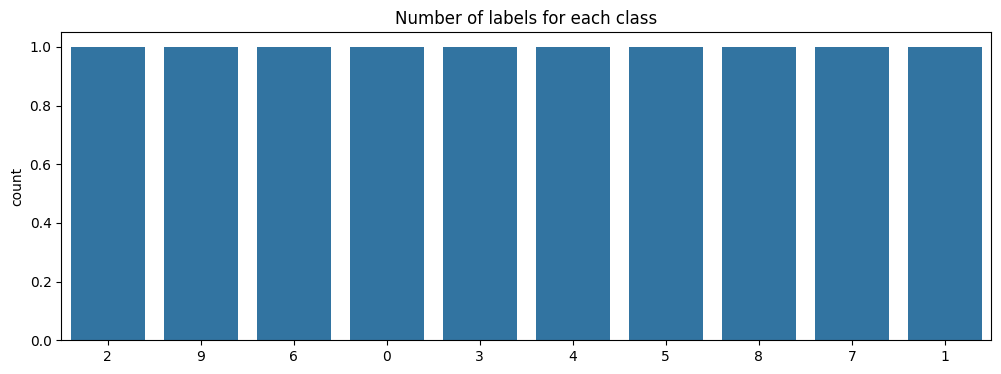

In [7]:
def plot_label_per_class(data):
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(data.label, order = data["label"].value_counts().index)
    g.set_title("Number of labels for each class")

    for p, label in zip(g.patches, data["label"].value_counts().index):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
    plt.show()  
    
plot_label_per_class(train_data)

In [8]:
get_classes_distribution(test_data)

T-shirt/top         :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Dress               :   1000 or 10.0%
Bag                 :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Ankle Boot          :   1000 or 10.0%


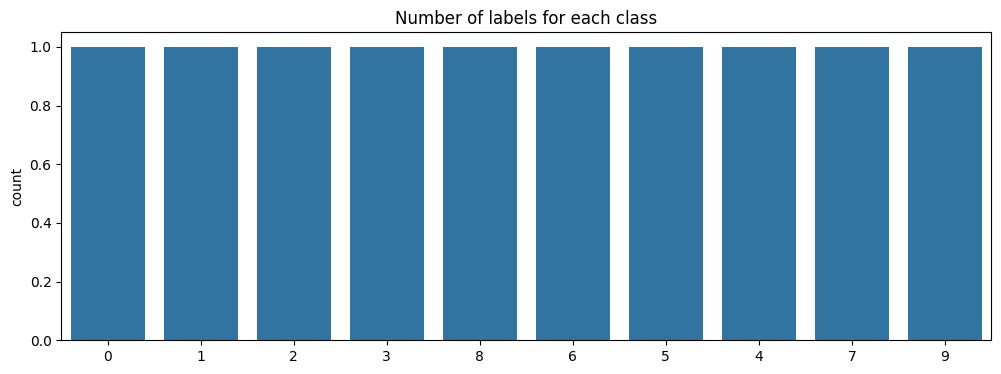

In [9]:
plot_label_per_class(test_data)

## Sample Images

### Train Set Sample Images

In [10]:
def sample_images_data(data):
    # An empty list to collect some samples
    sample_images = []
    sample_labels = []

    # Iterate over the keys of the labels dictionary defined in the above cell
    for k in labels.keys():
        # Get four samples for each category
        samples = data[data["label"] == k].head(4)
        # Append the samples to the samples list
        for j, s in enumerate(samples.values):
            # First column contain labels, hence index should start from 1
            img = np.array(samples.iloc[j, 1:]).reshape(IMG_ROWS,IMG_COLS)
            sample_images.append(img)
            sample_labels.append(samples.iloc[j, 0])

    print("Total number of sample images to plot: ", len(sample_images))
    return sample_images, sample_labels

train_sample_images, train_sample_labels = sample_images_data(train_data)

Total number of sample images to plot:  40


### Test Set Sample Images

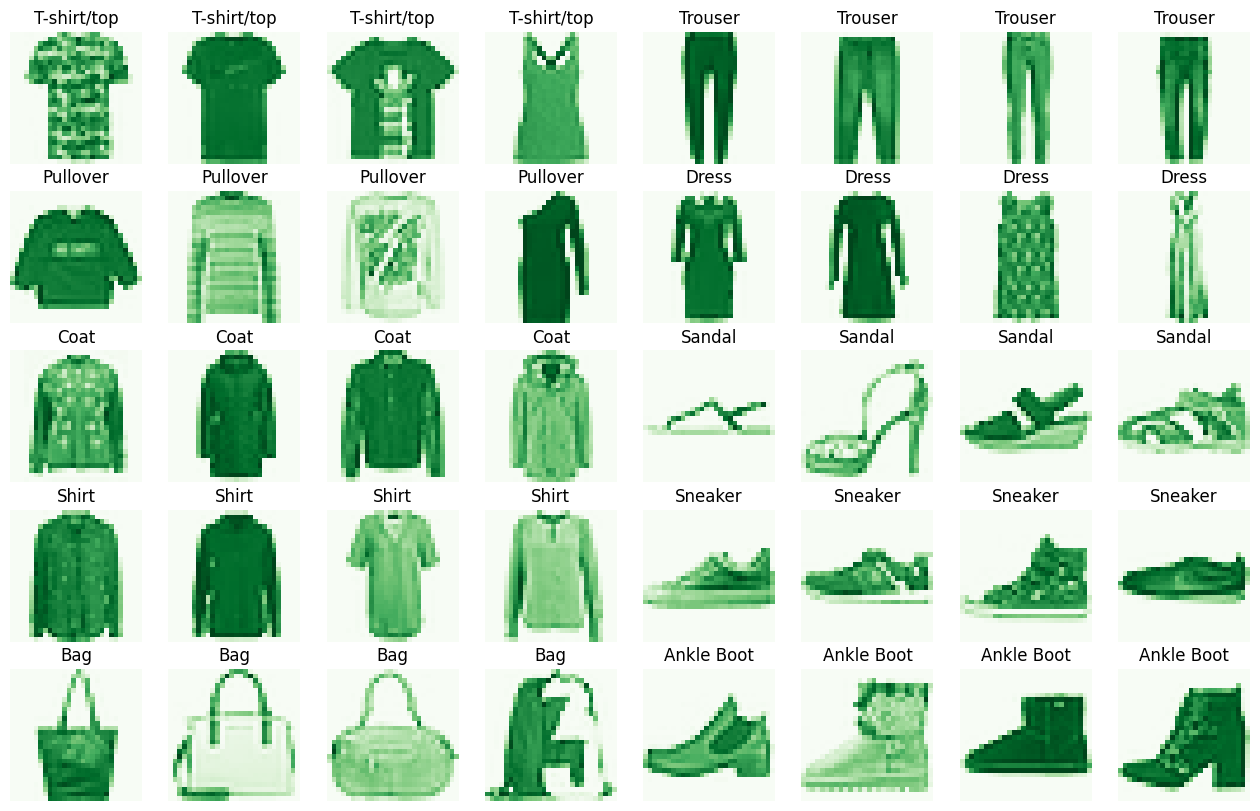

In [11]:
def plot_sample_images(data_sample_images,data_sample_labels,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(5,8, figsize=(16,10))

    for i, img in enumerate(data_sample_images):
        ax[i//8, i%8].imshow(img, cmap=cmap)
        ax[i//8, i%8].axis('off')
        ax[i//8, i%8].set_title(labels[data_sample_labels[i]])
    plt.show()    
    
plot_sample_images(train_sample_images,train_sample_labels, "Greens")

Total number of sample images to plot:  40


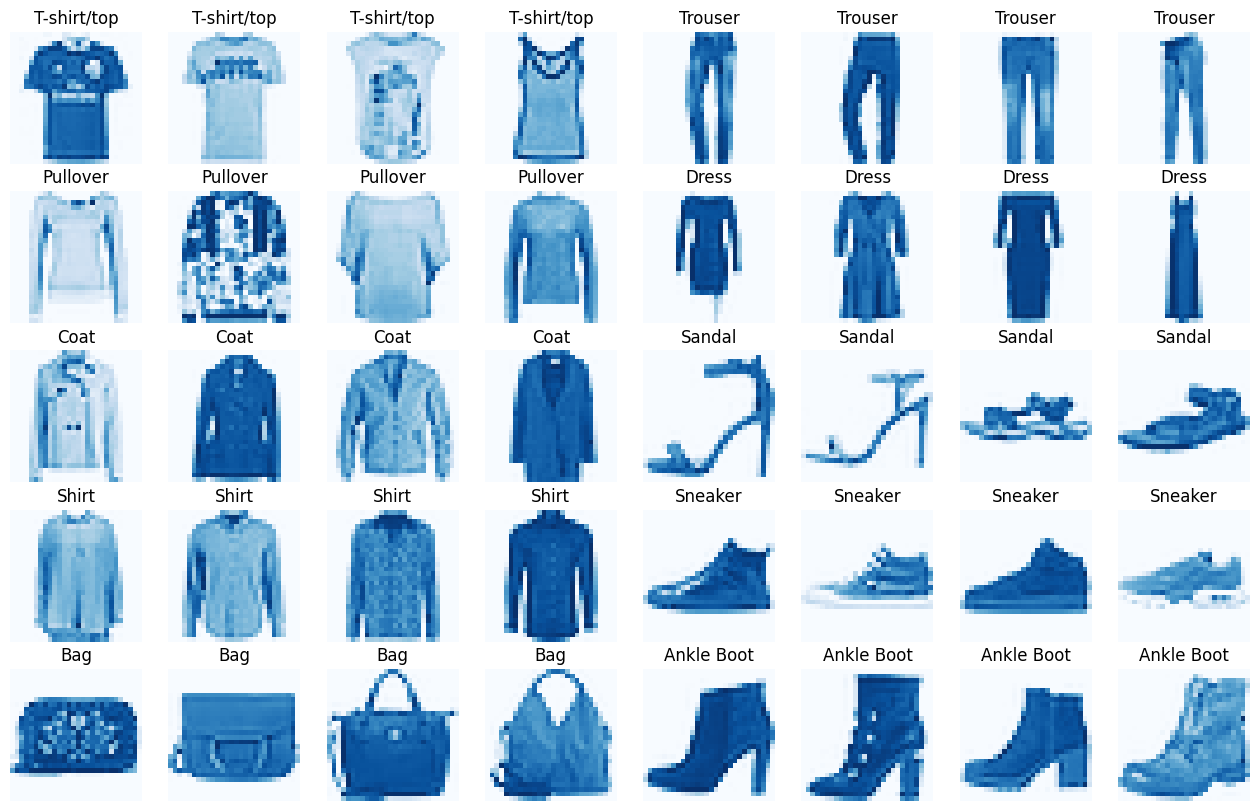

In [12]:
test_sample_images, test_sample_labels = sample_images_data(test_data)
plot_sample_images(test_sample_images,test_sample_labels)

## Model

### Data Preprocessing

In [13]:
# data preprocessing
def data_preprocessing(raw):
    out_y = keras.utils.to_categorical(raw.label, NUM_CLASSES)
    num_images = raw.shape[0]
    x_as_array = raw.values[:,1:]
    x_shaped_array = x_as_array.reshape(num_images, IMG_ROWS, IMG_COLS, 1)
    out_x = x_shaped_array / 255
    return out_x, out_y

### Preparing the Data

In [14]:
# prepare the data
X, y = data_preprocessing(train_data)
X_test, y_test = data_preprocessing(test_data)

### Train and Test Data Splitting

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

### Dimension of Train, Validation and Test sets

In [16]:
print("Fashion MNIST train -  rows:",X_train.shape[0]," columns:", X_train.shape[1:4])
print("Fashion MNIST valid -  rows:",X_val.shape[0]," columns:", X_val.shape[1:4])
print("Fashion MNIST test -  rows:",X_test.shape[0]," columns:", X_test.shape[1:4])

Fashion MNIST train -  rows: 48000  columns: (28, 28, 1)
Fashion MNIST valid -  rows: 12000  columns: (28, 28, 1)
Fashion MNIST test -  rows: 10000  columns: (28, 28, 1)


### Class Imbalance of training set

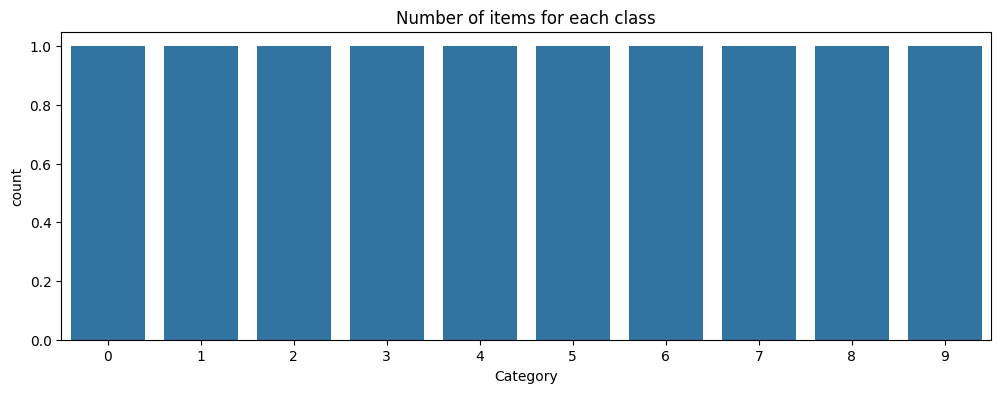

Dress               :   4891 or 10.189583333333333%
Sandal              :   4855 or 10.114583333333334%
Pullover            :   4836 or 10.075000000000001%
Ankle Boot          :   4827 or 10.05625%
Sneaker             :   4798 or 9.995833333333334%
Coat                :   4796 or 9.991666666666667%
Shirt               :   4779 or 9.95625%
Bag                 :   4757 or 9.910416666666666%
Trouser             :   4745 or 9.885416666666668%
T-shirt/top         :   4716 or 9.825000000000001%


In [17]:
def plot_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    f, ax = plt.subplots(1,1, figsize=(12,4))
    g = sns.countplot(ydf[0], order = np.arange(0,10))
    g.set_title("Number of items for each class")
    g.set_xlabel("Category")
    
    for p, label in zip(g.patches, np.arange(0,10)):
        g.annotate(labels[label], (p.get_x(), p.get_height()+0.1))
        
    plt.show()  

def get_count_per_class(yd):
    ydf = pd.DataFrame(yd)
    # Get the count for each label
    label_counts = ydf[0].value_counts()

    # Get total number of samples
    total_samples = len(yd)


    # Count the number of items in each class
    for i in range(len(label_counts)):
        label = labels[label_counts.index[i]]
        count = label_counts.values[i]
        percent = (count / total_samples) * 100
        print("{:<20s}:   {} or {}%".format(label, count, percent))
    
plot_count_per_class(np.argmax(y_train,axis=1))
get_count_per_class(np.argmax(y_train,axis=1))

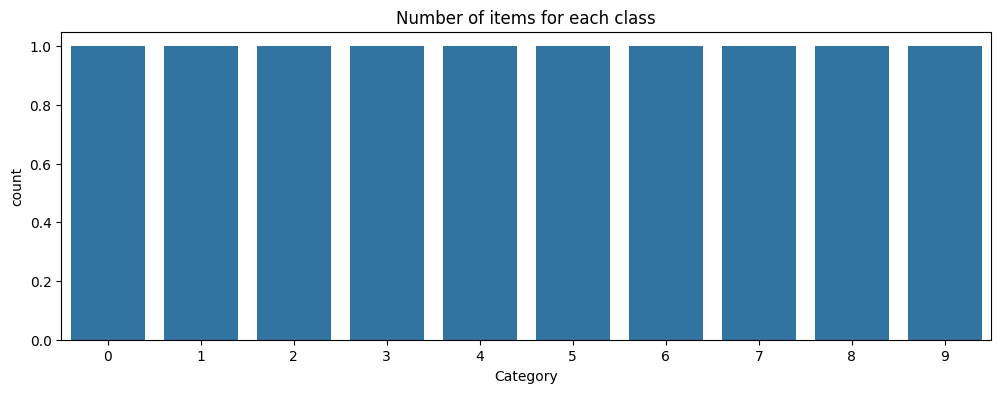

T-shirt/top         :   1284 or 10.7%
Trouser             :   1255 or 10.458333333333334%
Bag                 :   1243 or 10.358333333333333%
Shirt               :   1221 or 10.174999999999999%
Coat                :   1204 or 10.033333333333333%
Sneaker             :   1202 or 10.016666666666667%
Ankle Boot          :   1173 or 9.775%
Pullover            :   1164 or 9.700000000000001%
Sandal              :   1145 or 9.541666666666666%
Dress               :   1109 or 9.241666666666665%


In [18]:
plot_count_per_class(np.argmax(y_val,axis=1))
get_count_per_class(np.argmax(y_val,axis=1))

## Model Building

### Adding hidden layers and compiling the Model

In [19]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\Swarnadwip_Sarkar\anaconda3\envs\ML\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



### Summarize the model

In [20]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

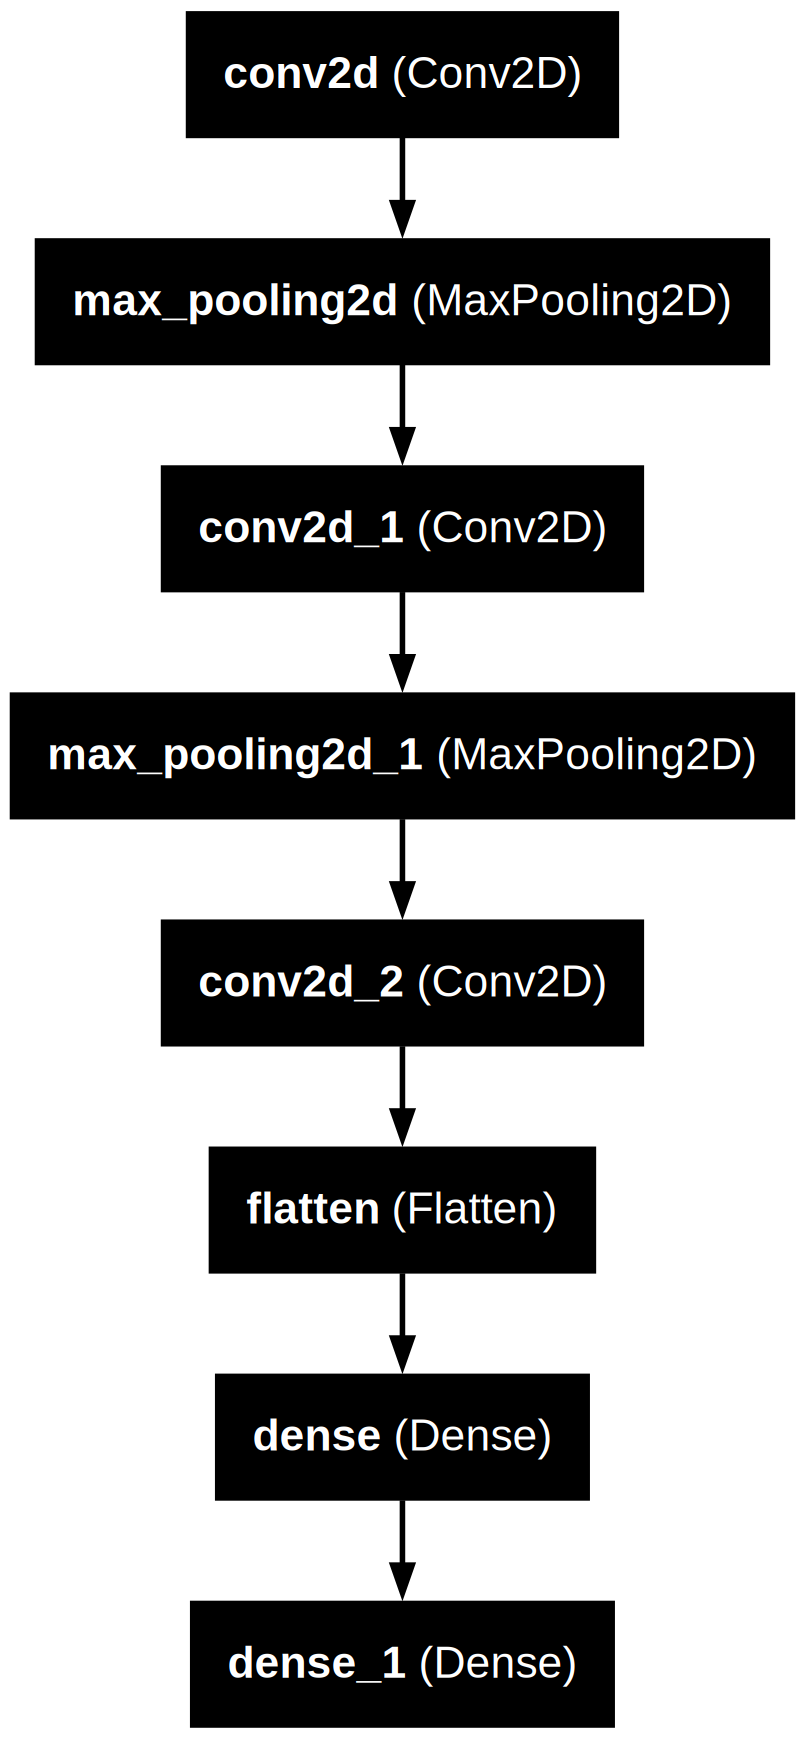

In [21]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Training the Model

In [22]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 22s 48ms/step - accuracy: 0.8040 - loss: 0.5391 - val_accuracy: 0.8499 - val_loss: 0.4140
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.8741 - loss: 0.3474 - val_accuracy: 0.8824 - val_loss: 0.3308
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.8903 - loss: 0.3013 - val_accuracy: 0.8954 - val_loss: 0.2979
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9017 - loss: 0.2676 - val_accuracy: 0.8976 - val_loss: 0.2892
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 41ms/step - accuracy: 0.9104 - loss: 0.2435 - val_accuracy: 0.9020 - val_loss: 0.2789
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9186 - loss: 0.2178 - val_accuracy: 0.9055 - val_loss: 0.2708
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.9248 - loss: 0.2011 - val_accuracy: 0.8993 - val_loss: 0.2843
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9314 - loss: 0.1859 - 

### Evaluating Test Loss and Accuracy

In [23]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7132218480110168
Test accuracy: 0.9132999777793884


### Validation Accuracy and Loss

In [24]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']         # updated key
    val_acc = hist['val_accuracy'] # updated key
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs, acc, "Training accuracy", "Green")
    trace_va = create_trace(epochs, val_acc, "Validation accuracy", "Red")
    trace_tl = create_trace(epochs, loss, "Training loss", "Blue")
    trace_vl = create_trace(epochs, val_loss, "Validation loss", "Magenta")
   
    fig = tools.make_subplots(rows=1, cols=2, subplot_titles=('Training and validation accuracy',
                                                              'Training and validation loss'))
    fig.append_trace(trace_ta, 1, 1)
    fig.append_trace(trace_va, 1, 1)
    fig.append_trace(trace_tl, 1, 2)
    fig.append_trace(trace_vl, 1, 2)
    
    fig['layout']['xaxis'].update(title='Epoch')
    fig['layout']['xaxis2'].update(title='Epoch')
    fig['layout']['yaxis'].update(title='Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title='Loss', range=[0,1])

    iplot(fig, filename='accuracy-loss')


plot_accuracy_and_loss(train_model)

c:\Users\Swarnadwip_Sarkar\anaconda3\envs\ML\lib\site-packages\plotly\tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Adding Dropout Layers to the Model

In [25]:
# Model
model = Sequential()
# Add convolution 2D
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=(IMG_ROWS, IMG_COLS, 1)))
model.add(MaxPooling2D((2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(64, 
                 kernel_size=(3, 3), 
                 activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Add dropouts to the model
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
# Add dropouts to the model
model.add(Dropout(0.3))
model.add(Dense(NUM_CLASSES, activation='softmax'))


model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

c:\Users\Swarnadwip_Sarkar\anaconda3\envs\ML\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



### Optimized Summarize Model

In [26]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,546 (943.54 KB)

 Trainable params: 241,546 (943.54 KB)

 Non-trainable params: 0 (0.00 B)

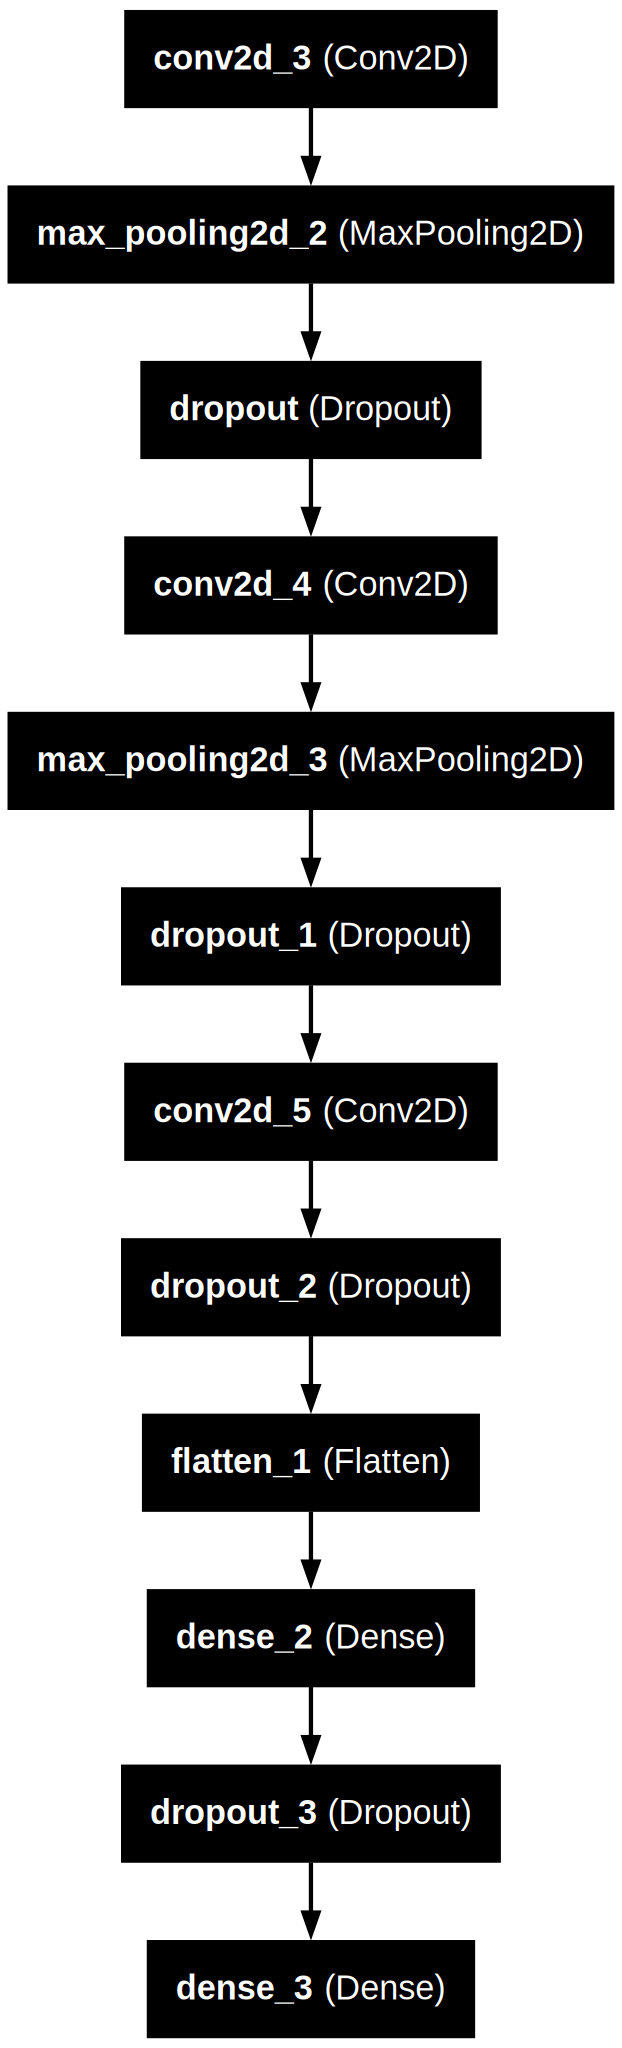

In [27]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))

### Optimized Training the Model

In [28]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7280 - loss: 0.7302 - val_accuracy: 0.8360 - val_loss: 0.4466
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8276 - loss: 0.4670 - val_accuracy: 0.8673 - val_loss: 0.3557
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8515 - loss: 0.4042 - val_accuracy: 0.8864 - val_loss: 0.3172
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8665 - loss: 0.3651 - val_accuracy: 0.8923 - val_loss: 0.3067
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.8746 - loss: 0.3394 - val_accuracy: 0.8928 - val_loss: 0.2908
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 18s 47ms/step - accuracy: 0.8820 - loss: 0.3226 - val_accuracy: 0.9004 - val_loss: 0.2686
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.8882 - loss: 0.3083 - val_accuracy: 0.9049 - val_loss: 0.2632
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.8924 - loss: 0.2965 - 

### Plotting the Accuracy and Loss of Train and Validation Datasets of the optimized Model

In [29]:
plot_accuracy_and_loss(train_model)

c:\Users\Swarnadwip_Sarkar\anaconda3\envs\ML\lib\site-packages\plotly\tools.py:453: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



### Optimized Test Loss and Accuracy

In [30]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2108679860830307
Test accuracy: 0.9254999756813049


## Prediction

In [31]:
# Get the predictions for the test data
y_pred_prob = model.predict(X_test)          # get predicted probabilities
predicted_classes = y_pred_prob.argmax(axis=1)  # convert to class indices

# Get the true labels
y_true = test_data.iloc[:, 0].values        # first column as numpy array


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


In [32]:
p = predicted_classes[:10000]
y = y_true[:10000]
correct = np.nonzero(p==y)[0]
incorrect = np.nonzero(p!=y)[0]

In [33]:
print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0])

Correct predicted classes: 9255
Incorrect predicted classes: 745


In [34]:
target_names = ["Class {} ({}) :".format(i,labels[i]) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

                         precision    recall  f1-score   support

Class 0 (T-shirt/top) :       0.87      0.88      0.88      1000
    Class 1 (Trouser) :       0.99      0.98      0.99      1000
   Class 2 (Pullover) :       0.92      0.87      0.89      1000
      Class 3 (Dress) :       0.91      0.95      0.93      1000
       Class 4 (Coat) :       0.91      0.86      0.89      1000
     Class 5 (Sandal) :       0.99      0.98      0.98      1000
      Class 6 (Shirt) :       0.77      0.81      0.78      1000
    Class 7 (Sneaker) :       0.95      0.98      0.96      1000
        Class 8 (Bag) :       0.99      0.99      0.99      1000
 Class 9 (Ankle Boot) :       0.97      0.96      0.97      1000

               accuracy                           0.93     10000
              macro avg       0.93      0.93      0.93     10000
           weighted avg       0.93      0.93      0.93     10000



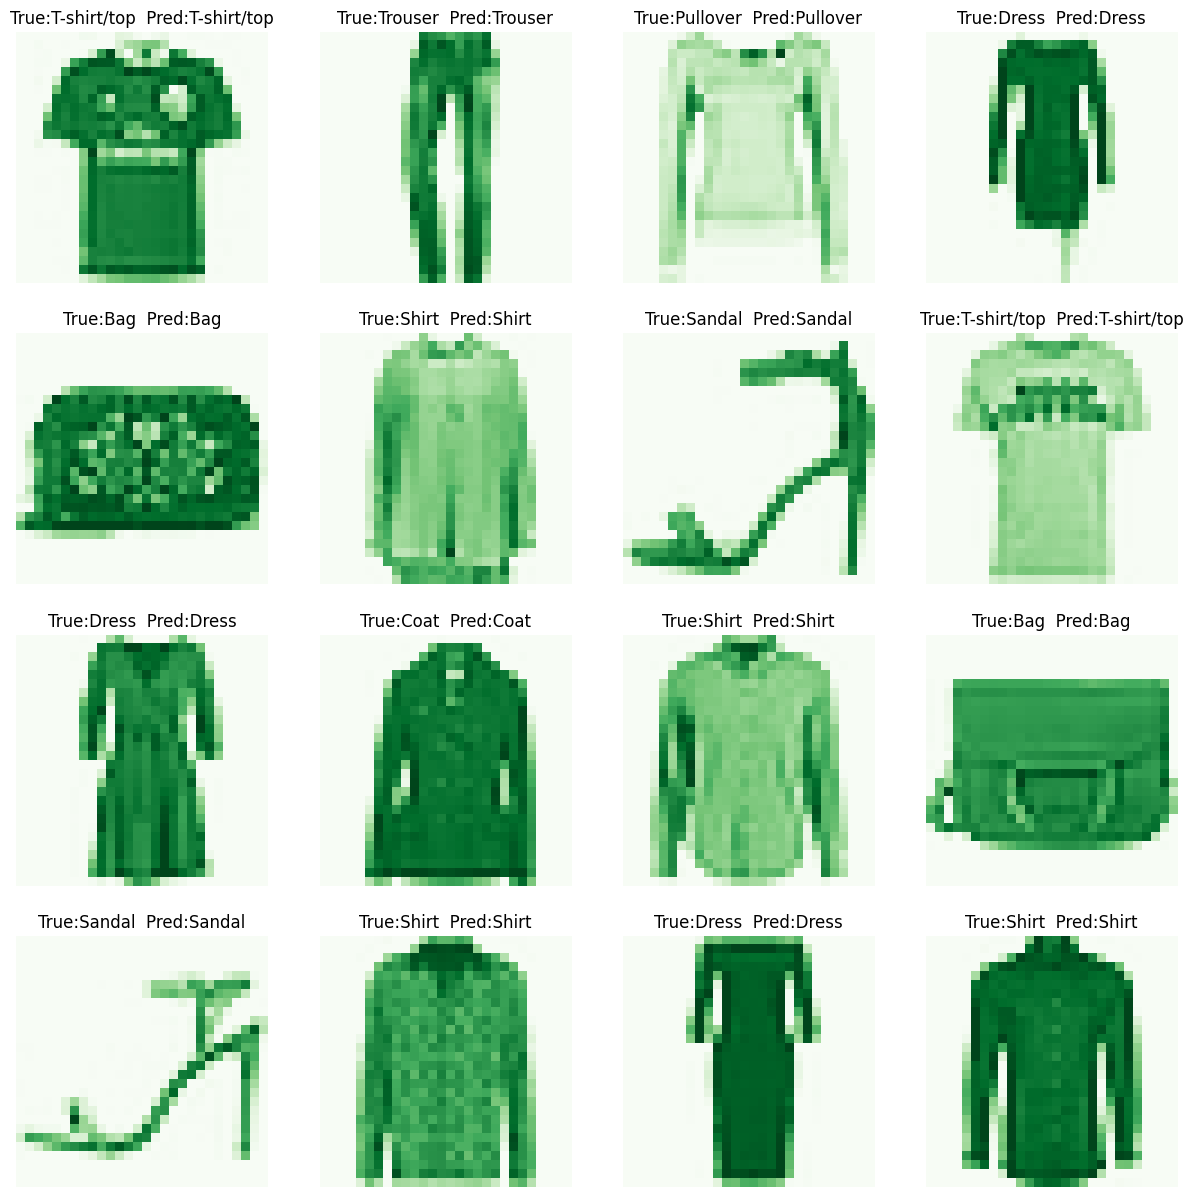

In [35]:
def plot_images(data_index,cmap="Blues"):
    # Plot the sample images now
    f, ax = plt.subplots(4,4, figsize=(15,15))

    for i, indx in enumerate(data_index[:16]):
        ax[i//4, i%4].imshow(X_test[indx].reshape(IMG_ROWS,IMG_COLS), cmap=cmap)
        ax[i//4, i%4].axis('off')
        ax[i//4, i%4].set_title("True:{}  Pred:{}".format(labels[y_true[indx]],labels[predicted_classes[indx]]))
    plt.show()    
    
plot_images(correct, "Greens")

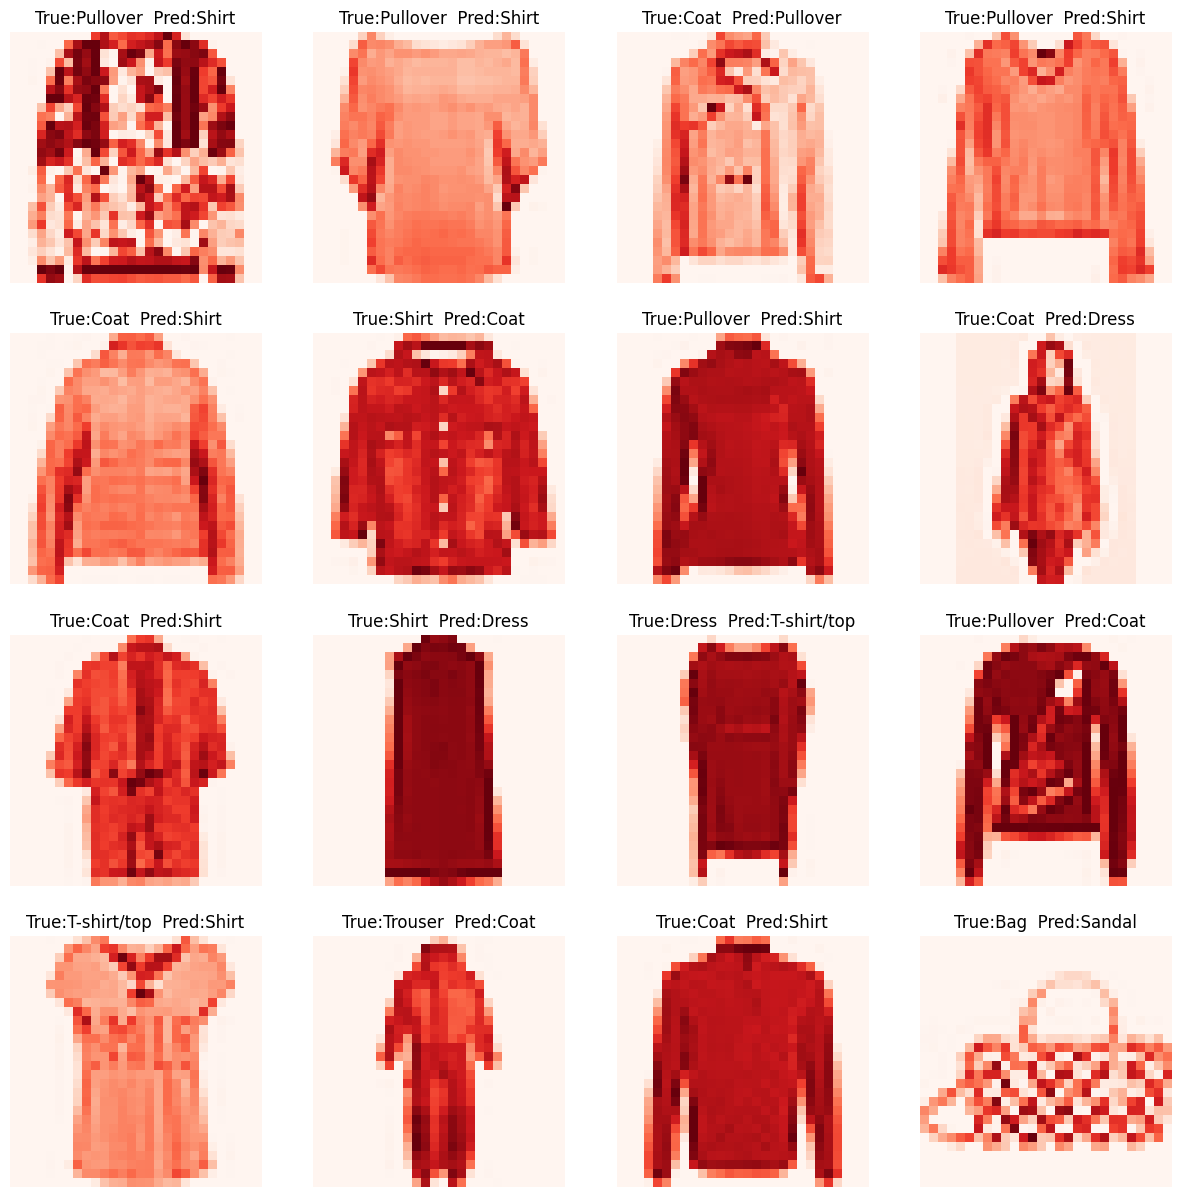

In [36]:
plot_images(incorrect, "Reds")

## Saving the Model

In [37]:
model.save("trained_model.keras")